figure = 66.66
bottle = 62.96
pen = 54.54

In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from metrics_utils import * 
from infer_utils import * 

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 3 #id of the object in the category

In [3]:
split_train = r"Bottle_train/"
split_test = r"Bottle_test/"

## Init the Valid Input Point Model 

In [4]:
args_infer = {
    "model_path" : "runs/bottle_2_single.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE,
    "rgb": True
}

In [5]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128,input_cls=1)
dataset_train = JacquardSamples(dataset_root= split_train ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=4)
dataset = JacquardSamples(dataset_root= split_test ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=7)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

## Init the Second Point UNet Model 

In [6]:
from unet import UNet

unet_path = 'runs/bottle_1_double_unet.ckpt'

In [7]:
n_channels = 2 
if args_infer["rgb"]:
    n_channels += 3 
unet = UNet(n_channels=n_channels,n_classes=1)
unet.load_state_dict(torch.load(unet_path)['weights'])
unet = unet.cuda()
unet.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [8]:
constrain_mode = True
TOPK = True
topk_grasps = 1
topk_input = 5

In [9]:
max_dist =0
min_dist = 999999
for i in range(len(dataset_train)):
    data = dataset_train[i]
    img = data["img"].to(device)
    img = torch.permute(img, (0, 2, 1))
    mask = data["mask"].sum().sqrt()
    all_points = torch.tensor(data["points_grasp"]//14)
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min() and dif_n.min()>0:
        min_dist = dif_n.min()
if min_dist < 0.01:
    min_dist = 0.01

/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
/home/cedric/ZeroShot-Grasping/MLP-approach/dataset_jacquard_samples.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)
/tmp/ipykernel_16236/3396165159.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(data["points_grasp"]//14)


### Loop over the data and get the metrics

In [10]:
import time
from tabulate import tabulate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 0
Total accuracy is 100.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/cedric/anaconda3/envs/4D-humans/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid

Total accuracy is 74.07407407407408


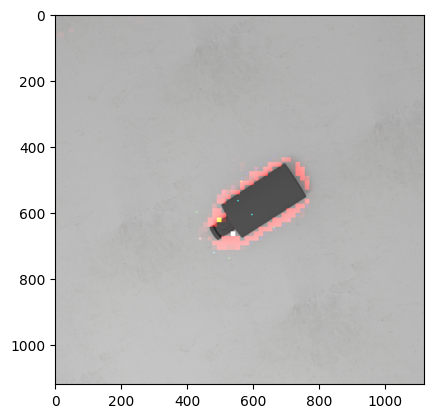

In [11]:
%load_ext autoreload
accuracies = []
print_every = 100
print_time = False
for test_idx in range(len(dataset)): 
    #test_idx = 13
    start = time.time()
    data = dataset[test_idx]
    img = data["img"].to(device)
    resized_img = data['resized_img'].to(device)
    mask = data["mask"].to(device)
    resized_mask = data['resized_mask'].to(device)
    img = torch.permute(img, (0, 2, 1))
    grasp = data["points_grasp"]//14
    normal_grasp = grasp.clone()
    grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
    grasp = torch.cat([grasp, grasp_inv], dim=0)
    #get features from dino
    
    features,_ = model.forward_dino_features(img.unsqueeze(0))
    features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

    #plt.figure(figsize=(16,16))
    org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
    end = time.time() - start
    #plt.imshow(org_image)


    ## get valid points
    all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)

    start_valid_pts = time.time()
    preds, preds_patches = get_valid_points(all_points, features, model, device,PATCH_DIM=PATCH_DIM)
    end_valid_pts = time.time() - start_valid_pts 
    
    start_topk = time.time()
    preds_cp, pts, valid_pts_pred = get_topk_valid_points(preds,preds_patches, mask, topk_num=topk_input,TOP_K=TOPK)
    end_topk = time.time() - start_topk
    
    #get second point information using the unet inference 
    start_second_point = time.time()
    unet_preds, conf_vals = get_unet_preds(unet,valid_pts_pred,resized_mask,resized_img,args_infer)
    #need to add it to items array here 
    items = []
    #import pdb; pdb.set_trace()
    for i in range(len(unet_preds)):
        item = {}
        origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
        try : 
            origin_point[:, valid_pts_pred[i][0][0], valid_pts_pred[i][0][1]] = [0, 1, 0]
        except : 
            origin_point[:, int(valid_pts_pred[i][0][0].item()), int(valid_pts_pred[i][0][1].item())] = [0, 1, 0]
        
        top_x = int(unet_preds[i][0].item()) 
        top_y = int(unet_preds[i][1].item()) 
        if constrain_mode == True : 
            origin_point[:, top_x, top_y] = [0, 1, 1]
        origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
        
    
        item['origin_point'] = origin_point
        item['preds'] = preds
        item['single_point'] = valid_pts_pred[i][0] * 14 + 7
        item['pred_point'] = unet_preds[i] * 14 + 7
        item['conf'] = conf_vals[i].item()
        items.append(item)
        #items.append([valid_pts_pred[i],unet_preds[i]])
    
    end_second_point = time.time() - start_second_point
    num_grasps = valid_pts_pred.shape[0]
    #objs = 1


    datas = {}
    datas['mask'] = mask
    datas['valid_pts_pred'] = valid_pts_pred
    datas['min_dist'] = min_dist
    datas['max_dist'] = max_dist
    datas['heights'] = data['height'] 
    datas['args_infer'] = args_infer
    datas['mask_n'] = data["mask"]
    datas['device'] = device
    datas['features'] = features
    #data['model_single'] = model_single

    ##currently only support constraint mode == false

        

    start_vis = time.time()
    #try : 
    cur_accuracy = vis_preds_with_metrics(num_grasps, items, org_image, grasp,datas['heights'], args_infer,preds_cp,topks=topk_grasps,vis=False)
    accuracies.append(cur_accuracy) 
    #except : 
    #    print("eval issue")
    end_vis = time.time() - start_vis
        
    #except : 
    
    if print_time == True : 
        all_runtime = float(end + end_valid_pts + end_topk + end_second_point +  end_vis) 
        data = [['Dinov2',round(end / all_runtime,4) * 100, round(end,4) * 1000], 
                ['Valid Points', round(end_valid_pts/ all_runtime,2) * 100, round(end_valid_pts,4) * 1000],    
                ['Topk', round(end_topk/ all_runtime,4) * 100, round(end_topk,4) * 1000],
                ['Second Point', round(end_second_point/ all_runtime,4) * 100, round(end_second_point,4) * 1000],
                ['Visualization',round( end_vis/ all_runtime,4) * 100,round(end_vis,4) * 1000],       
        ]
        
        headers = ['Module Type', 'Runtime Percentage', 'Time in ms']
        table = tabulate(data, headers=headers, tablefmt="grid")
        print(table)
    
    
    
        
    #except : 
    #    print('issue with eval')
    #    #accuracies.append(0)
    
    #print("idx", test_idx)

    if test_idx % print_every == 0: 
        print("Iteration", test_idx)
        print('Total accuracy is', sum(accuracies)/len(accuracies))

        
print('Total accuracy is', sum(accuracies)/len(accuracies))


